# Notebook 2: Calculating global temperature anomalies

Importing necessary python libraries

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# netCDF4 needs to be installed in your environment for this to work
import xarray as xr
import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

#### Importing the data. We use the data obtained in N1_InitialAnalysis and processing (Notebook 1) for this analysis

In [95]:
monthly_avg_path = "D:\monthlyaverages.nc" #importing long term monthly averages, this data contains a month's average for 72 years eg: 72 years of January ab.
monthly_avg = xr.open_dataset(monthly_avg_path)
longterm_averages = monthly_avg['t2m']

In [98]:
path = "D:\monthly.nc" #importing monthly data of temperatures from 1950 to 2022
temp_xr = xr.open_dataset(path)
temperature_data = temp_xr['t2m']

# Calculating Temperature Anomalies 


## Monthly Anomalies
We subtract monthly temperature data by average temperature for that month in the past 30 years as discussed in the Methodology section. Refer ReadME to know more.

In [18]:
anomalies = []
i = 0

In [2]:
# Advice: If this gives computational bottlenecks then follow this approach:
# first loop for first 100 values like: for k in range(0,100):
# then, do it for the next 100 values and etc...: for k in range(100,200)...

for k in range(0,len(temperature_data)):
    x = np.subtract(temperature_data[k], longterm_averages[i%12])    
    anomalies.append(x)
    i = i + 1
len(anomalies) #There's around 871 values. so, see to it that it matches.

In [37]:
anom = xr.DataArray(data = anomalies, coords = temperature_data.coords, dims = temperature_data.dims) #save anomalies into an xarray dataframe
anom = anom.__xarray_dataarray_variable__

In [6]:
# Save the anomaly grid as a netCDF file for backup or further use.
anom.to_netcdf(path= "D:\monthlyanomaly.nc")

In [35]:
#Process anomalies data in a form that enables us to convert it into xarray dataframe. 
anm = []
for i in anom:
    anm.append(i.mean(skipna=True))
monthly_anomaly = anm
anm = np.array(anm)

anm = xr.DataArray(data = monthly_anomaly, coords = anom.time.coords) #Store anomalies into a xarray dataframe
anm

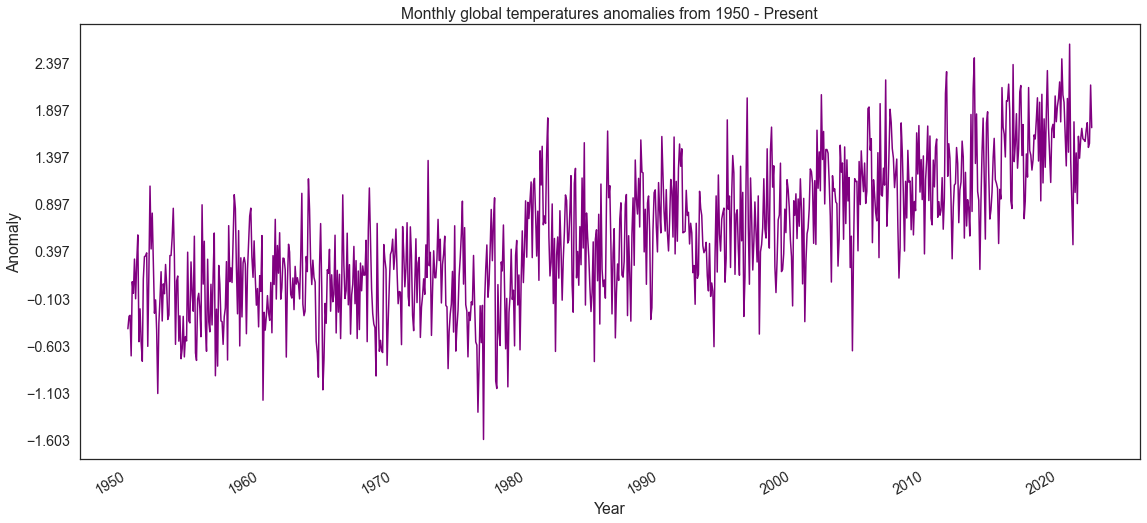

In [88]:
#Visualize global temperature anomalies
f, ax = plt.subplots(figsize=(19, 8))
plt.yticks(np.arange(min(anm), max(anm)+0.2, 0.5))
           
anm.plot(hue='lat',ax=ax,color="purple",label ='Mean temperature')
plt.xlabel('Year')
plt.ylabel('Anomaly')
plt.title('Monthly global temperatures anomalies from 1950 - Present')
plt.savefig('MonthlyGlobalTempAnomalies.png')

In [91]:
monthly_anomalies = anm.to_pandas()
monthly_anomalies.to_csv("monthlyanomalies.csv") #save the values as csv

## Yearly Anomalies

We subtract yearly average from yearly data to get yearly anomalies.

In [103]:
yearly_averages = xr.open_dataset("D:/yearlyaverages.nc") #import the yearly averages data 
yearly_averages = yearly_averages['t2m']

In [107]:
climatology = yearly_averages.mean(dim = ["year"]) #Get mean of long term yearly data

In [110]:
yearly_data = xr.open_dataset("D:/yearly.nc") #import yearly temperature data

In [112]:
yearly_anomalies = (yearly_data - climatology) #Calculate temperature anomaly formula 

In [116]:
yearly_anomalies.to_netcdf("D:/yearlyanomalies.nc") #save the values into a netCDF file.

In [117]:
anomalies = yearly_anomalies.mean(("longitude", "latitude"), skipna=True) #calculates mean global anomalies for a year.

In [120]:
yearly_anomalies = anomalies #just renaming
yearly_anomalies = yearly_anomalies['t2m']

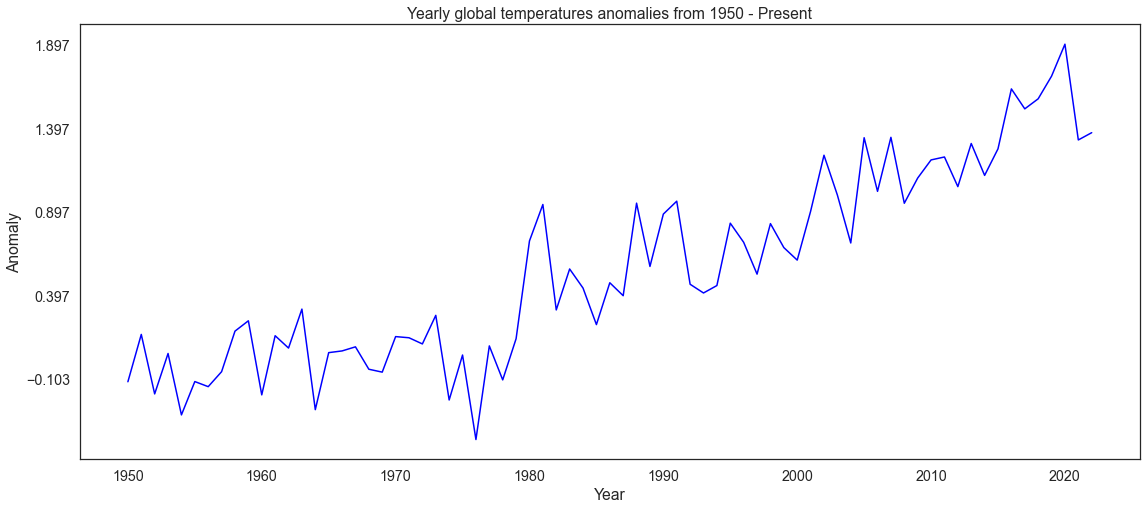

In [124]:
#visualizing the yearly temperature anomaly plots.
f, ax = plt.subplots(figsize=(19, 8))
plt.yticks(np.arange(min(anm), max(anm)+0.2, 0.5))
           
yearly_anomalies.plot(hue='lat',ax=ax,color="blue",label ='Mean temperature')
plt.xlabel('Year')
plt.ylabel('Anomaly')
plt.title('Yearly global temperatures anomalies from 1950 - Present')
plt.savefig('YearlyGlobalTempAnomalies.png')

# A comparision with commonly used publications
Compared the results with popular results in the public domain, such as NASA NOAA, Berkeley Earth, Japanese Meterological Agency.

In [128]:
berk = pd.read_csv("berk.csv")
data = pd.read_csv("data.csv")
jma = pd.read_csv("year_wld.csv")
df["year"] = yearly_anomalies.year
df["ours"] = pd.DataFrame(yearly_anomalies)

In [150]:
df["ours"].to_csv("yearlyanomalies.csv")

In [157]:
df=df.drop(0,axis=1)
df

,ours,berk,data,jma,year
0,-0.119846,0.010,0.00,-0.50,1950
1,0.163479,0.082,0.05,-0.48,1951
2,-0.192571,0.156,0.13,-0.41,1952
3,0.049414,-0.036,-0.10,-0.64,1953
4,-0.318179,-0.093,-0.13,-0.67,1954
...,...,...,...,...,...
68,1.573546,1.016,0.94,0.31,2018
69,1.709053,1.042,0.97,0.34,2019
70,1.900473,0.889,0.84,0.22,2020
71,1.327371,NaN,NaN,NaN,2021


In [141]:
df["berk"] = berk["Values"]
df["data"] = data["Value"]
df["jma"] = jma["Global"]

Text(0.5, 1.0, 'Comparision between anomalies')

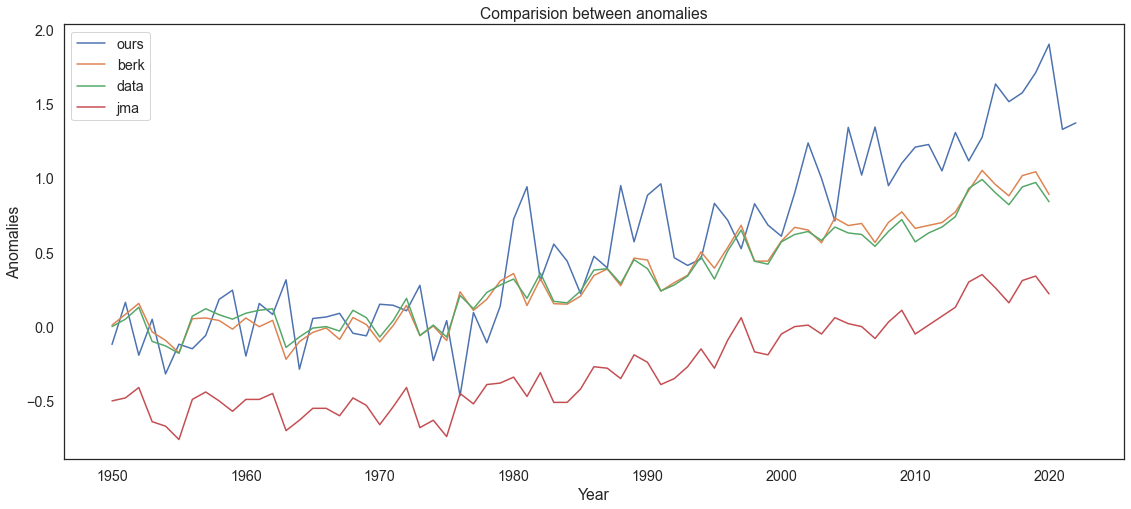

In [158]:
#Plots to visualize trends in the data available.
f, ax = plt.subplots(figsize=(19, 8))

df.plot(ax=ax,label ='Mean temperature', x = "year")
plt.xlabel('Year')
plt.ylabel('Anomalies')
plt.title('Comparision between anomalies')

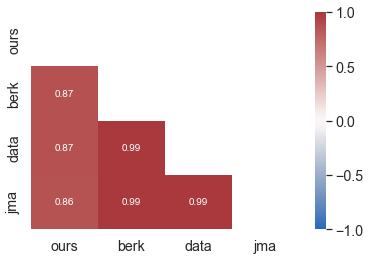

In [149]:
#Creating a correlation matrix to check the correlation between differeent datasets.
matrix = df.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

### Reasons for discrepancy: 
The data used in other methods considers both land surface temperature and sea surface temperature data, while ours consider temperature 2m above the land surface. Ocean is relatively cooler at surface and below surface levels, while land surface such as sand gets hotter faster than air. Methodology used for calculation is the same for all the methods.  